# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import auc, roc_curve, f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
# !pip install hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.ensemble import RandomForestClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import itertools

In [2]:
try:
    data = pd.read_csv('datasets/Churn.csv', sep=',')
except FileNotFoundError: 
    data = pd.read_csv('/datasets/Churn.csv', sep=',')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [38]:
rng = 12345

## Подготовка данных

### Выбираем признаки.

In [5]:
data.columns = data.columns.str.lower() 

In [6]:
data.exited.value_counts(normalize=True).apply(lambda x : str(x*100)[:5] + ' %')

0    79.63 %
1    20.36 %
Name: exited, dtype: object

* в выборке дисбаланс классов примерно 80 на 20

In [7]:
data_use_col = data.drop(['rownumber', 'customerid', 'surname'], axis=1) # исключаем лишние индексы

In [8]:
data_ohe_use_col = pd.get_dummies(data_use_col, columns=['gender', 'geography'], drop_first=True)
data_ohe_use_col.head() 

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,gender_Male,geography_Germany,geography_Spain
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


### Заполняем пропуски.
* Поскольку пропуски есть только в одном столбце, попробуем запонить их предсказаниями "легкой" модели на основе решающего дерева.

<AxesSubplot:>

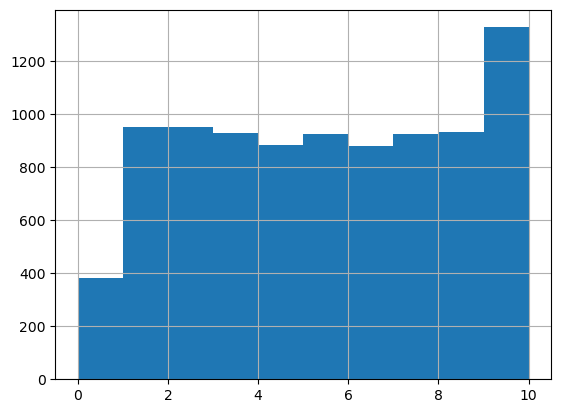

In [9]:
data.tenure.hist()

In [10]:
feature_tenure_train = data_ohe_use_col.loc[data_ohe_use_col.tenure.isnull() == False].drop(['tenure', 'exited'], axis=1)
feature_tenure_test = data_ohe_use_col.loc[data_ohe_use_col.tenure.isnull() == True].drop(['tenure', 'exited'], axis=1)

target_tenure_train = data_ohe_use_col['tenure'].loc[data_ohe_use_col.tenure.isnull() == False]


dtr_tenure = RandomForestClassifier()
dtr_tenure.fit(feature_tenure_train, target_tenure_train)

data_ohe_use_col['tenure'].fillna(pd.Series(dtr_tenure.predict(feature_tenure_test), index = feature_tenure_test.index), inplace=True)

<AxesSubplot:>

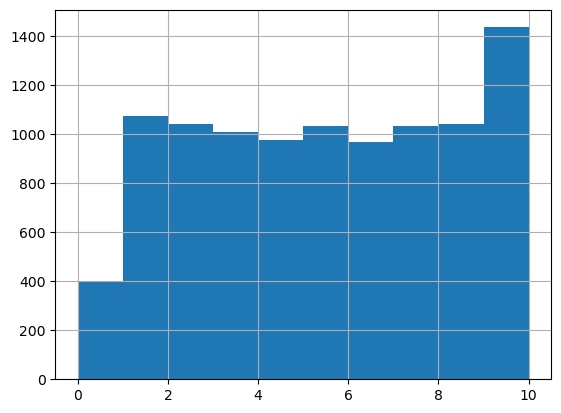

In [11]:
data_ohe_use_col.tenure.hist()

In [12]:
data_ohe_use_col.tenure = data_ohe_use_col.tenure.astype('int64')

In [13]:
pd.DataFrame(round(data_ohe_use_col.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
creditscore,0.000000
age,0.000000
tenure,0.000000
balance,0.000000
numofproducts,0.000000
hascrcard,0.000000
isactivemember,0.000000
estimatedsalary,0.000000
exited,0.000000
gender_Male,0.000000


## Исследование задачи

### Задаем фичи и целевую пременную.

In [14]:
features = data_ohe_use_col.drop('exited', axis=1)
target = data_ohe_use_col.exited

### Делим выборку на обучающую и тестовую.

In [15]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=rng,
                                                                            test_size=0.20
                                                                           )

In [16]:
np.random.seed(0)

### Находим оптимальные гиперпараметры.
* При помощи HyperOpt найдем оптимальные гиперпараметры для моделей. 
* Для функции потерь используем метрики менее чувствительные к дисбалансу классов, чем F-мера.

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [18]:
def score_cbc(params):
    auc = cross_val_score(estimator= CatBoostClassifier(**params, random_state=rng), 
                        X=features_train, 
                        y=target_train, 
                        scoring='roc_auc', 
                        cv=cv, 
                        n_jobs=-1
                       )
    result = {'loss': 1- auc.mean(), 'status': STATUS_OK}
    print('TEST ROC-AUC: {0:.4f}'.format(auc.mean()))
    return result


space = {'max_depth' : hp.quniform('max_depth', 5, 10, 1),
         'n_estimators' : scope.int(hp.quniform('n_estimators', 100, 500, 100)),
         'learning_rate': hp.quniform('learning_rate', 0.01, 0.05, 0.01)
         }
trials = Trials()

best_params_cbc = fmin(score_cbc, space, algo=tpe.suggest, trials=trials, max_evals=10)
best_params_cbc

TEST ROC-AUC: nan                                     
 10%|█         | 1/10 [00:06<00:54,  6.01s/trial, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mig29fulcrum\AppData\Roaming\Python\Python39\site-packages\catboost\core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\mig29fulcrum\AppData\Roaming\Python\Python3

TEST ROC-AUC: 0.8633                                          
TEST ROC-AUC: 0.8692                                                            
TEST ROC-AUC: 0.8572                                                             
TEST ROC-AUC: 0.8646                                                             
TEST ROC-AUC: 0.8665                                                             
TEST ROC-AUC: 0.8671                                                             
TEST ROC-AUC: 0.8660                                                             
TEST ROC-AUC: 0.8673                                                             
TEST ROC-AUC: 0.8629                                                             
100%|██████████| 10/10 [00:37<00:00,  3.72s/trial, best loss: 0.13076429592045025]


{'learning_rate': 0.04, 'max_depth': 5.0, 'n_estimators': 200.0}

In [19]:
def score_rfc(params_rfc):
    auc = cross_val_score(estimator= RandomForestClassifier(**params_rfc, random_state=rng), 
                        X=features_train, 
                        y=target_train, 
                        scoring='roc_auc', 
                        cv=cv, 
                        n_jobs=-1
                       )
    result_rfc = {'loss': 1- auc.mean(), 'status': STATUS_OK}
    print('TEST ROC-AUC: {0:.4f}'.format(auc.mean()))
    return result_rfc 


space_rfc = {'max_depth' :  scope.int(hp.quniform('max_depth', 5, 10, 1)),
         'n_estimators' : scope.int(hp.quniform('n_estimators', 100, 500, 100))
         }
trials_rfc = Trials()

best_params_rfc = fmin(score_rfc, space_rfc, algo=tpe.suggest, trials=trials_rfc, max_evals=20)

TEST ROC-AUC: 0.8557                                  
TEST ROC-AUC: 0.8591                                                             
TEST ROC-AUC: 0.8577                                                             
TEST ROC-AUC: 0.8464                                                             
TEST ROC-AUC: 0.8582                                                             
TEST ROC-AUC: 0.8590                                                             
TEST ROC-AUC: 0.8547                                                             
TEST ROC-AUC: 0.8578                                                             
TEST ROC-AUC: 0.8592                                                             
TEST ROC-AUC: 0.8600                                                             
TEST ROC-AUC: 0.8553                                                              
TEST ROC-AUC: 0.8478                                                              
TEST ROC-AUC: 0.8583                     

In [20]:
best_params_rfc = {k: int(v) for k, v in best_params_rfc.items()}
best_params_rfc

{'max_depth': 9, 'n_estimators': 400}

In [21]:
# функция расчета AUC и построения графика ROC кривой.
def calc_auc(target, target_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(target, target_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label, )
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.grid()
    return auc_val

### Для анализа F-меры и ROC-AUC для разных стратегий борьбы с дисбалансом будем использовать:
* градиентный бустинг (CatBoost)
* лес (RandomForrest)

In [22]:
CBC = CatBoostClassifier(**best_params_cbc,
                           logging_level='Silent',
                           random_state=rng)

In [23]:
RFС = RandomForestClassifier(**best_params_rfc, random_state=rng)

In [24]:
# функция обучения моделей на разных выборках и выводом метрик.
def model_show_metrics(model, features_train, features_test, target_train, target_test):
    model.fit(features_train, target_train)
    target_pred_test = model.predict(features_test)
    target_pred_train = model.predict(features_train)
    target_pred_prob_test = model.predict_proba(features_test)[:, 1]
    target_pred_prob_train = model.predict_proba(features_train)[:, 1]
    
    print('Train:')
    print ('F-МЕРА: {0:.4f}'.format(f1_score(target_train, target_pred_train)))
    calc_auc(target_train, target_pred_prob_train, 'train')
    print()
    print('Test:')
    print ('F-МЕРА: {0:.4f}'.format(f1_score(target_test, target_pred_test)))
    calc_auc(target_test, target_pred_prob_test, 'test')
    print()
    plt.legend();
    plt.grid()
    print('Распрееление классов:')
    print(target_train.value_counts())

### Расчитаем метрики для  выборки с несбалансированными классами.

Train:
F-МЕРА: 0.6108
ROC AUC: 0.8884

Test:
F-МЕРА: 0.5896
ROC AUC: 0.8814

Распрееление классов:
0    6390
1    1610
Name: exited, dtype: int64


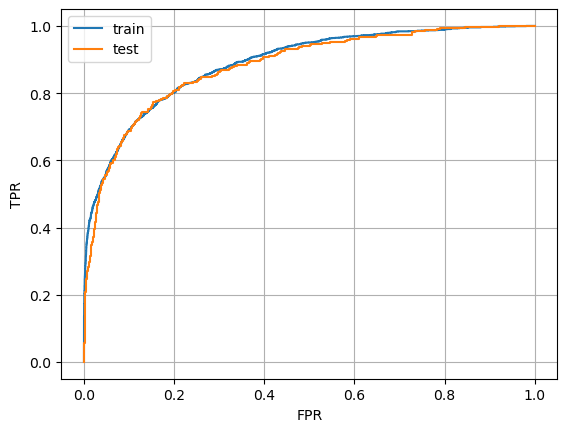

Train:
F-МЕРА: 0.6495
ROC AUC: 0.9322

Test:
F-МЕРА: 0.5281
ROC AUC: 0.8712

Распрееление классов:
0    6390
1    1610
Name: exited, dtype: int64


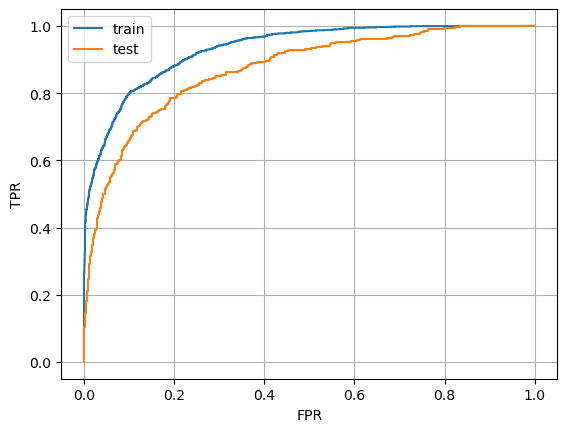

In [25]:
model_show_metrics(CBC, features_train, features_test, target_train, target_test)
plt.show()
model_show_metrics(RFС, features_train, features_test, target_train, target_test)

### Выводы:
* По графикам, значениям ROC-AUC и F-меры видно, что лес слегка переобучен.
* Значение F-меры упало на тестовой выборке и оно меньше целевых 0.59.

## Борьба с дисбалансом

### Для борьбы с дисбалансом будут применены 4 стратегии:
* Уменьшение выборки.
* Увеличение выборки.
* Алгоритм SMOTE
* Алгоритм NearMiss

### Уменьшение выборки:

In [26]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rng)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rng)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=rng)
    
    return features_downsampled, target_downsampled

In [27]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

### Увеличение выборки:

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rng)
    
    return features_upsampled, target_upsampled

In [29]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

### Алгоритм SMOTE

In [32]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=rng)
features_smote, target_smote= smote.fit_resample(features_train, target_train)

### Алгоритм NearMiss

In [33]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=3, n_neighbors=5, n_neighbors_ver3=5)
features_nm, target_nm = nm.fit_resample(features_train, target_train)

## Тестирование модели

### Обучение моделей и расчет метрик на уменшенной выборке:

Train:
F-МЕРА: 0.8176
ROC AUC: 0.9046

Test:
F-МЕРА: 0.6299
ROC AUC: 0.8753

Распрееление классов:
1    1610
0    1598
Name: exited, dtype: int64


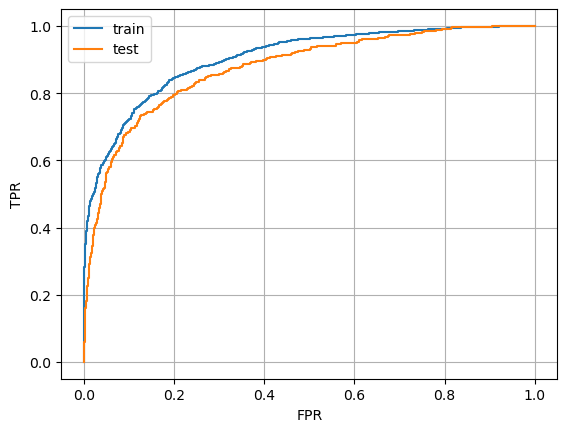

Train:
F-МЕРА: 0.8732
ROC AUC: 0.9588

Test:
F-МЕРА: 0.6157
ROC AUC: 0.8673

Распрееление классов:
1    1610
0    1598
Name: exited, dtype: int64


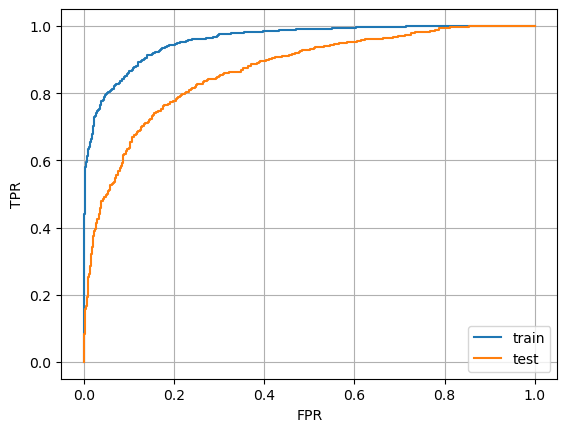

In [34]:
model_show_metrics(CBC, features_downsampled, 
                   features_test,
                   target_downsampled, 
                   target_test 
                   )
plt.show()

model_show_metrics(RFС, features_downsampled, 
                   features_test,
                   target_downsampled, 
                   target_test 
                   )

### Обучение моделей и расчет метрик на увеличенной выборке:

Train:
F-МЕРА: 0.8022
ROC AUC: 0.8967

Test:
F-МЕРА: 0.6484
ROC AUC: 0.8785

Распрееление классов:
1    6440
0    6390
Name: exited, dtype: int64


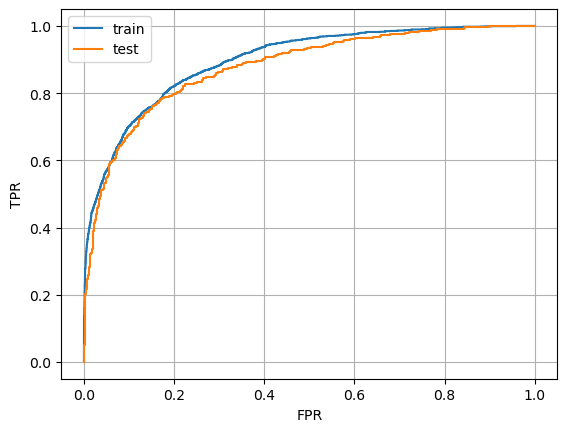

Train:
F-МЕРА: 0.8544
ROC AUC: 0.9404

Test:
F-МЕРА: 0.6344
ROC AUC: 0.8695

Распрееление классов:
1    6440
0    6390
Name: exited, dtype: int64


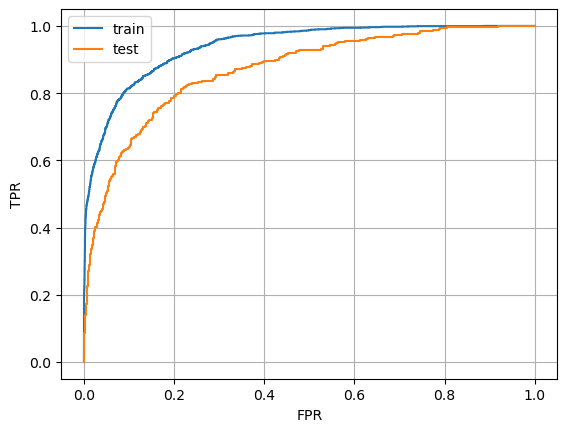

In [35]:
model_show_metrics(CBC,features_upsampled, 
                   features_test, 
                   target_upsampled, 
                   target_test, 
                   )
plt.show()
model_show_metrics(RFС,features_upsampled, 
                   features_test, 
                   target_upsampled, 
                   target_test, 
                   )

### Обучение моделей и расчет метрик на выровненной алгоритмом SMOTE выборке:

Train:
F-МЕРА: 0.8481
ROC AUC: 0.9256

Test:
F-МЕРА: 0.6014
ROC AUC: 0.8437

Распрееление классов:
0    6390
1    6390
Name: exited, dtype: int64


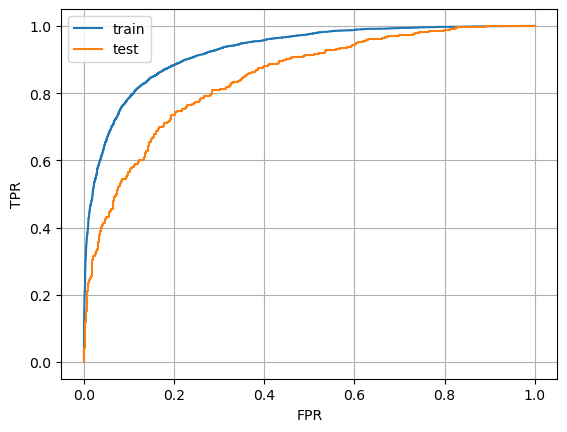

Train:
F-МЕРА: 0.8708
ROC AUC: 0.9494

Test:
F-МЕРА: 0.5673
ROC AUC: 0.8269

Распрееление классов:
0    6390
1    6390
Name: exited, dtype: int64


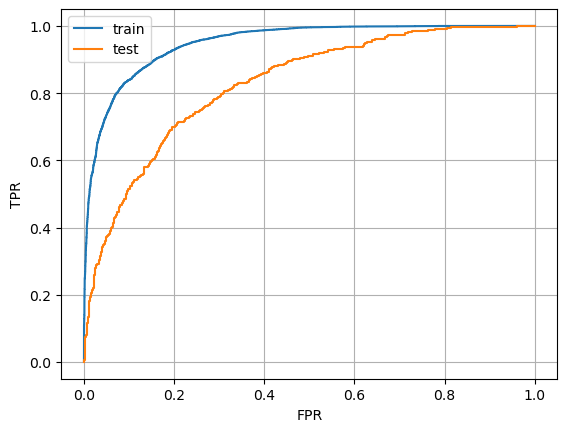

In [36]:
model_show_metrics(CBC,features_smote, 
                   features_test, 
                   target_smote,
                   target_test)
plt.show()

model_show_metrics(RFС,features_smote, 
                   features_test, 
                   target_smote,
                   target_test)

### Обучение моделей и расчет метрик на выровненной алгоритмом NearMiss выборке:

Train:
F-МЕРА: 0.8417
ROC AUC: 0.9300

Test:
F-МЕРА: 0.4142
ROC AUC: 0.6643

Распрееление классов:
0    1610
1    1610
Name: exited, dtype: int64


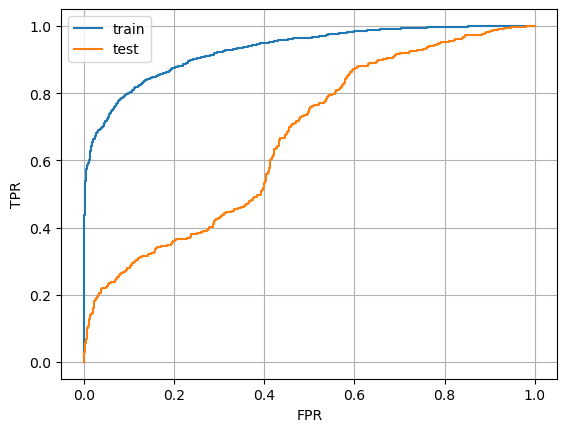

Train:
F-МЕРА: 0.8597
ROC AUC: 0.9565

Test:
F-МЕРА: 0.4166
ROC AUC: 0.6150

Распрееление классов:
0    1610
1    1610
Name: exited, dtype: int64


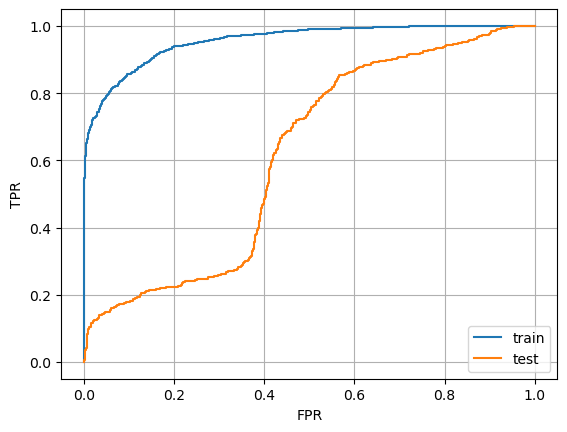

In [37]:
model_show_metrics(CBC,features_nm, 
                   features_test, 
                   target_nm,
                   target_test)
plt.show()

model_show_metrics(RFС,features_nm, 
                   features_test, 
                   target_nm,
                   target_test)

### Выводы:
* Хуже всех справился алгоритм NearMiss (изменение параметров алгоритма почти никак не влияет). Наблюдается сильное падение AUC на тестовой выборке в районе высоких порогов.
* F-меру повысили все стратегии кроме NearMiss на тестовой выборке.
* Применение алгоритмов SMOTE и NearMiss привели к переобучению обеих моделей.
* По совокупности метрик и графиков лучшая стратегия из рассматриваемых - увеличение выборки.